In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jdatetime as jd
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler


Read data






In [14]:
input_data=pd.read_csv("weather.csv", header=4)
#input_data
#input_data.info()
#input_data.describe()

Data Casting

In [15]:
def auto_data_type(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        min_value = df[col].min()
        max_value = df[col].max()

        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(np.float32)
        elif min_value >= 0:
            if max_value <= 255:
                df[col] = df[col].astype(np.uint8)
            elif max_value <= 65535:
                df[col] = df[col].astype(np.uint16)
            elif max_value <= 4294967295:
                df[col] = df[col].astype(np.uint32)
            else:
                df[col] = df[col].astype(np.uint64)
        else:
            if -128 <= min_value and max_value <= 127:
                df[col] = df[col].astype(np.int8)
            elif -32768 <= min_value and max_value <= 32767:
                df[col] = df[col].astype(np.int16)
            elif -2147483648 <= min_value and max_value <= 2147483647:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
    return df


clean_df=auto_data_type(input_data)

clean_df["daylight_duration (s)"]=(clean_df["daylight_duration (s)"]/60).astype(np.uint16)

clean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4386 entries, 0 to 4385
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   location_id               4386 non-null   uint8  
 1   time                      4386 non-null   object 
 2   precipitation_sum (mm)    4386 non-null   float32
 3   rain_sum (mm)             4386 non-null   float32
 4   snowfall_sum (cm)         4386 non-null   float32
 5   sunrise (iso8601)         4386 non-null   object 
 6   sunset (iso8601)          4386 non-null   object 
 7   daylight_duration (s)     4386 non-null   uint16 
 8   temperature_2m_mean (°C)  4386 non-null   float32
 9   temperature_2m_max (°C)   4386 non-null   float32
 10  temperature_2m_min (°C)   4386 non-null   float32
dtypes: float32(6), object(3), uint16(1), uint8(1)
memory usage: 218.6+ KB


Remove duplicated and null records


In [16]:
#clean_df.duplicated()
#clean_df.isnull()

Split data into cities

In [17]:
city_labels = {0: "Tehran", 1: "Qom", 2: "Rasht"}
clean_df["city"] = clean_df["location_id"].map(city_labels)

clean_df_tehran = clean_df[clean_df["location_id"] == 0]
clean_df_qom = clean_df[clean_df["location_id"] == 1]
clean_df_rasht = clean_df[clean_df["location_id"] == 2]

Extract Features

In [18]:
main_df = clean_df.copy()

main_df["month"] = pd.to_datetime(main_df["time"]).dt.month
main_df["year"]  = pd.to_datetime(main_df["time"]).dt.year

main_df["time"] = pd.to_datetime(main_df["time"])

main_df["month_sh"] = main_df["time"].dt.date.apply(
    lambda d: jd.date.fromgregorian(date=d).month
)
monthly_sh = (
    main_df
    .groupby(["city", "month_sh"])["precipitation_sum (mm)"]
    .mean()
    .reset_index()
)


clean_df["time"] = pd.to_datetime(clean_df["time"])

def seasons_jalali(date):
    jdate = jd.date.fromgregorian(date=date)
    if jdate.month in [1, 2, 3]:
        return 'spring'
    elif jdate.month in [4, 5, 6]:
        return 'summer'
    elif jdate.month in [7, 8, 9]:
        return 'fall'
    else:
        return 'winter'

clean_df["season"] = clean_df["time"].map(seasons_jalali)

main_df["year"] = pd.to_datetime(main_df["time"]).dt.year
main_df["season"] = main_df["time"].map(seasons_jalali)


Scaling/Normalization

In [19]:
#چون میزان بارش در شهر رشت زیاد بوده و دو شهر دیگه تقریبا بارش نزدیک به صفر داشتند برای ارزیابی بهتر از MinMax scaler استفاده می کنیم
df_norm = main_df.copy()

# نرمال‌سازی بارش به صورت جداگانه برای هر شهر
scaler = MinMaxScaler()
df_norm["precip_norm"] = (
    df_norm
    .groupby("city")["precipitation_sum (mm)"]
    .transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).flatten())
)


Data Distribution

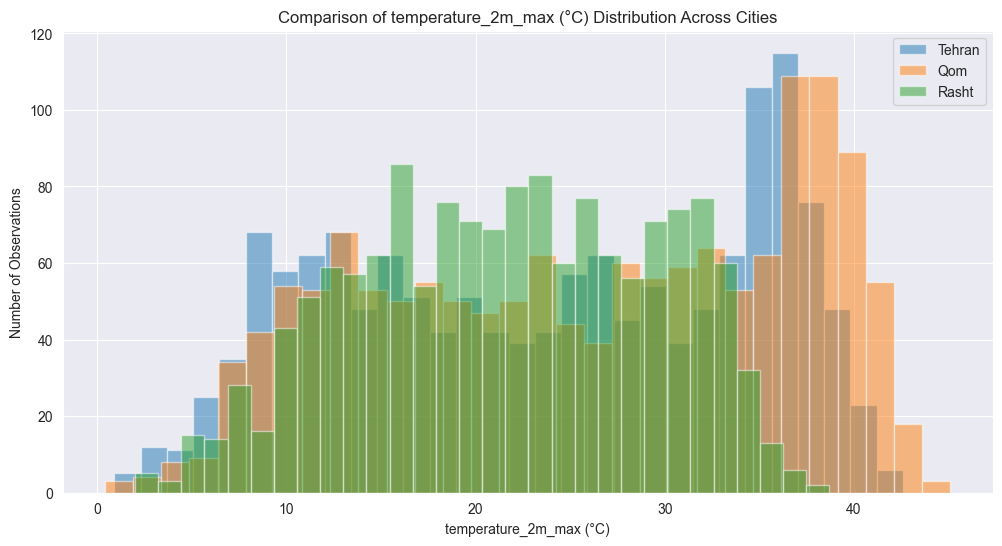

In [20]:
cities = main_df["city"].unique()
column = "temperature_2m_max (°C)"

plt.figure(figsize=(12, 6))
for city in cities:
    city_data = main_df[main_df["city"] == city][column]
    plt.hist(city_data, bins=30, alpha=0.5, label=city)

plt.title(f"Comparison of {column} Distribution Across Cities")
plt.xlabel(column)
plt.ylabel("Number of Observations")
plt.legend()
plt.grid(True)
plt.show()


Finding the influencing factors

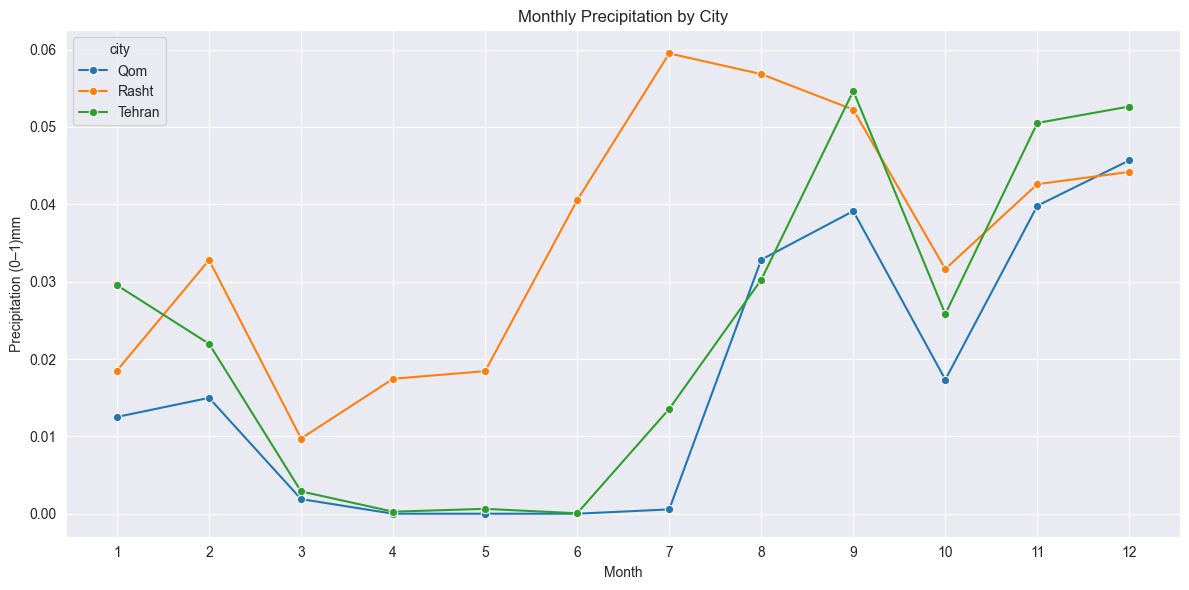

C:\Users\Mohammad\AppData\Local\Temp\ipykernel_17180\3255527830.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_17180\3255527830.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_17180\3255527830.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_17180\3255527830.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

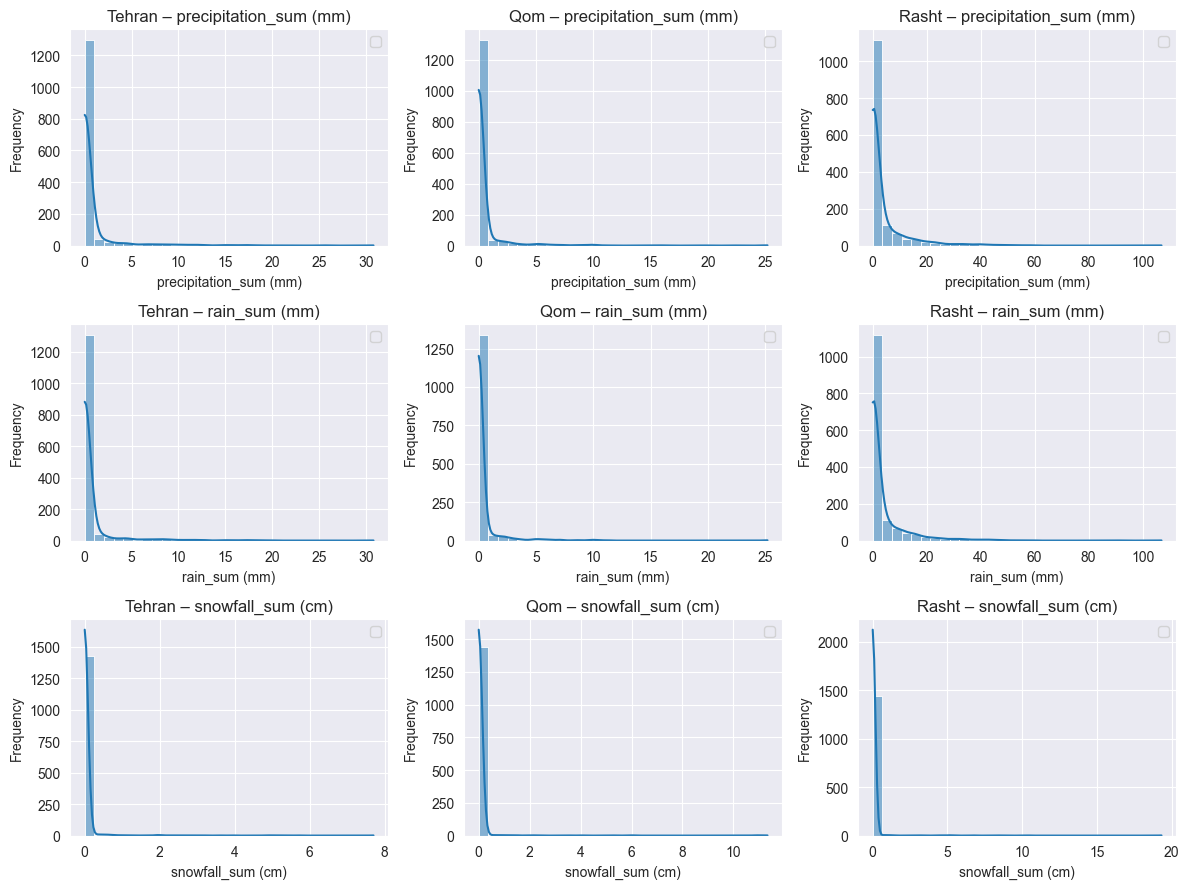

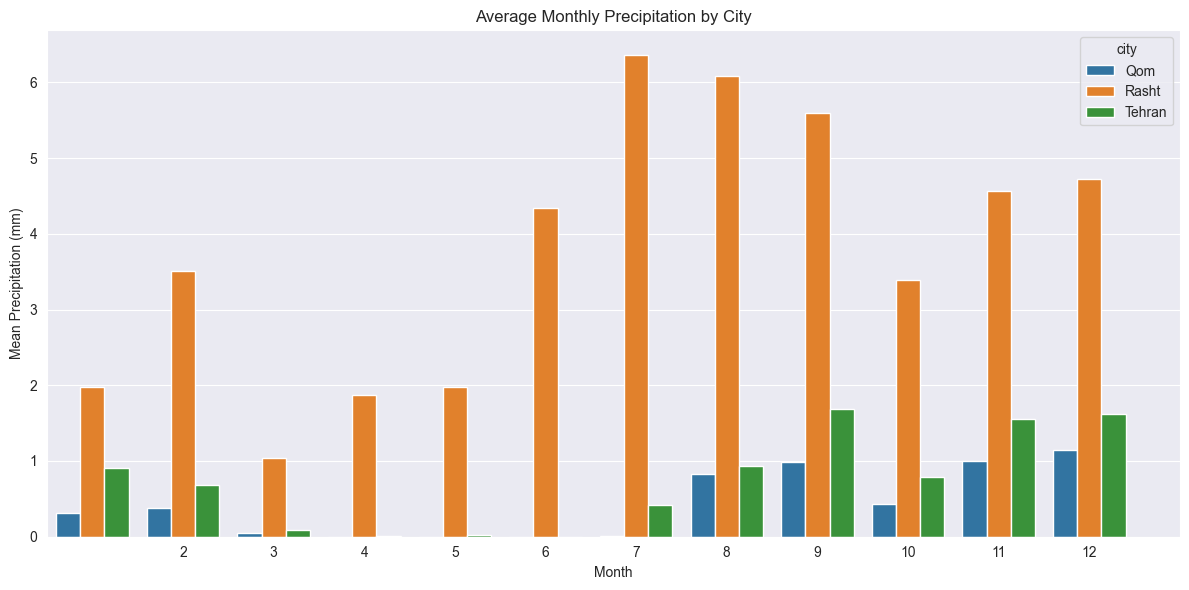

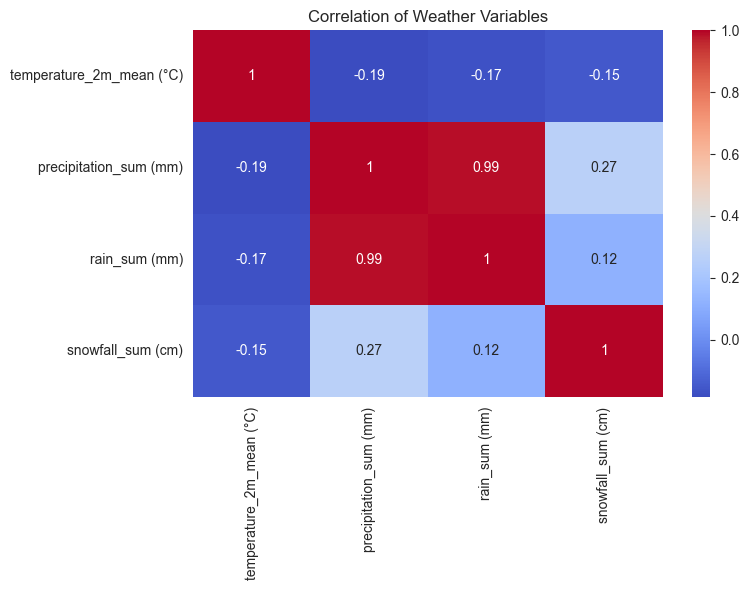

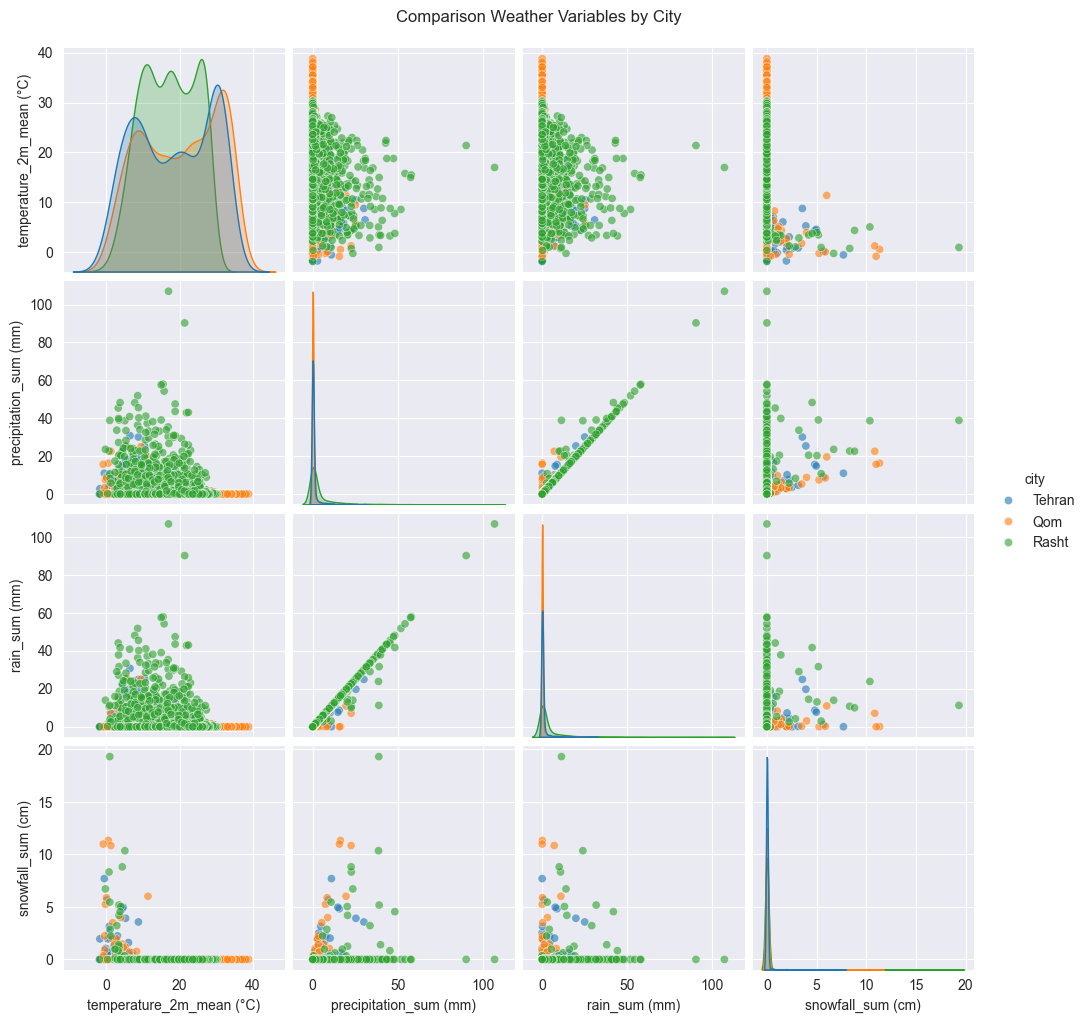

In [21]:
# محاسبه میانگین بارش ماهانه
monthly_norm = (
    df_norm
    .groupby(["city", "month_sh"])["precip_norm"]
    .mean()
    .reset_index()
)

# رسم نمودار جدید با داده نرمال‌شده
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_norm,
    x="month_sh",
    y="precip_norm",
    hue="city",
    marker="o"
)
plt.title("Monthly Precipitation by City")
plt.xlabel("Month")
plt.ylabel("Precipitation (0–1)mm")
plt.xticks(range(1,13))
plt.legend(title="city")
plt.grid(True)
plt.tight_layout()
plt.show()


#مشاهده می شود که تو هر سه شهر بیشتر روزا یا بارونی هست یا خیلی کم بارون می‌بارد، و فقط رشت یک سری روز های پر بارش و حتی برفی دارد


variables = ["precipitation_sum (mm)", "rain_sum (mm)", "snowfall_sum (cm)"]
cities    = main_df["city"].unique()

fig, axes = plt.subplots(len(variables), len(cities), figsize=(12, 9), sharex=False, sharey=False)

for i, var in enumerate(variables):
    for j, city in enumerate(cities):
        ax = axes[i, j]
        subset = main_df[main_df["city"] == city]
        sns.histplot(subset[var], bins=30, kde=True, ax=ax)
        ax.set_title(f"{city} – {var}")
        ax.set_xlabel(var)
        ax.set_ylabel("Frequency")
        ax.legend()

plt.tight_layout()
plt.show()


#از این نمودار می‌توان نتیجه گرفت که رشت در تمام طول سال به‌مراتب مرطوب‌تر است و اوج بارش آن در اواخر پاییز و زمستان (آبان، آذر، دی و بهمن) رخ می‌دهد، در حالی که قم و تهران در اغلب ماه‌ها تقریباً خشک‌اند و تنها در فصل زمستان (دی تا اسفند) کمی بارش دریافت می‌کنند.



plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_sh,
    x="month_sh",
    y="precipitation_sum (mm)",
    hue="city"
)
plt.title("Average Monthly Precipitation by City")
plt.xlabel("Month")
plt.ylabel("Mean Precipitation (mm)")
plt.xticks(range(1, 13))
plt.legend(title="city")
plt.tight_layout()
plt.show()



### در این نقشه‌ی همبستگی به‌خوبی دیده می‌شود که میانگین دما و میزان بارش رابطه‌ای معکوس دارند؛ یعنی معمولاً وقتی بارش افزایش می‌یابد، دما کمی کاهش می‌یابد. همچنین بارش کلی و میزان باران تقریباً یکسان عمل می‌کنند و هیچ تمایز معناداری بین آن‌ها وجود ندارد، در حالی که الگوی برف‌بارش مستقل است و با باران یا بارش کلی همزمانی‌ چندانی ندارد.


numeric_cols = [
    "temperature_2m_mean (°C)",
    "precipitation_sum (mm)",
    "rain_sum (mm)",
    "snowfall_sum (cm)"
]
plt.figure(figsize=(8, 6))
sns.heatmap(main_df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Weather Variables")
plt.tight_layout()
plt.show()

sns.pairplot(
    data=main_df[numeric_cols + ["city"]],
    hue="city",
    diag_kind="kde",
    plot_kws={"alpha": 0.6}
)
plt.suptitle("Comparison Weather Variables by City", y=1.02)
plt.show()


<p style={text-align=right}>با توجه به نمودار های بالا ، شهر قم با میانگین دمای بالا تر، دارای بارش کمتری است. در مقابل، شهر رشت که میانگین دمای آن نسبت به قم و تهران پایین ‌تر است، بارش بیشتری را تجربه می‌کند. این موضوع نشان می ‌دهد که بین عوامل دمای هوا و میزان بارش، رابطه‌ای معکوس وجود دارد. پس می توان استنباط کرد که هرچه دما پایین ‌تر باشد، احتمال بارندگی بیشتر است. </p>


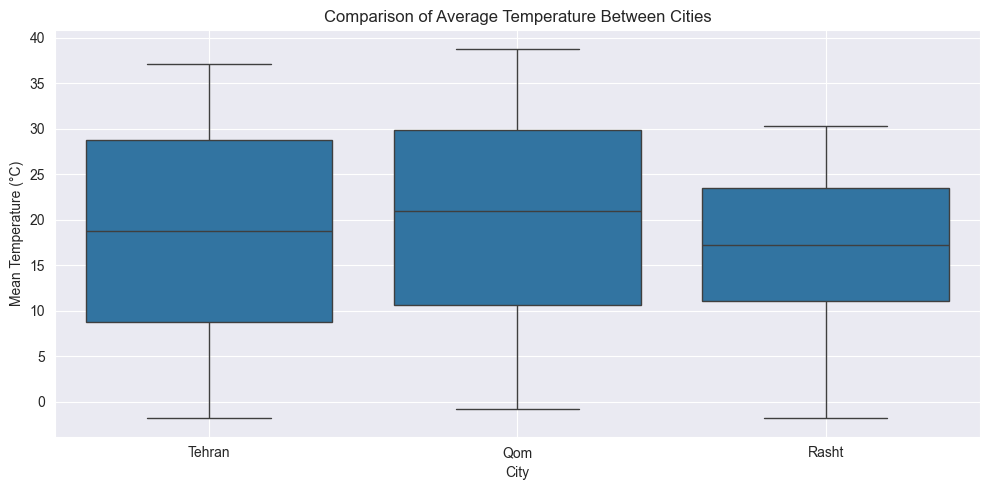

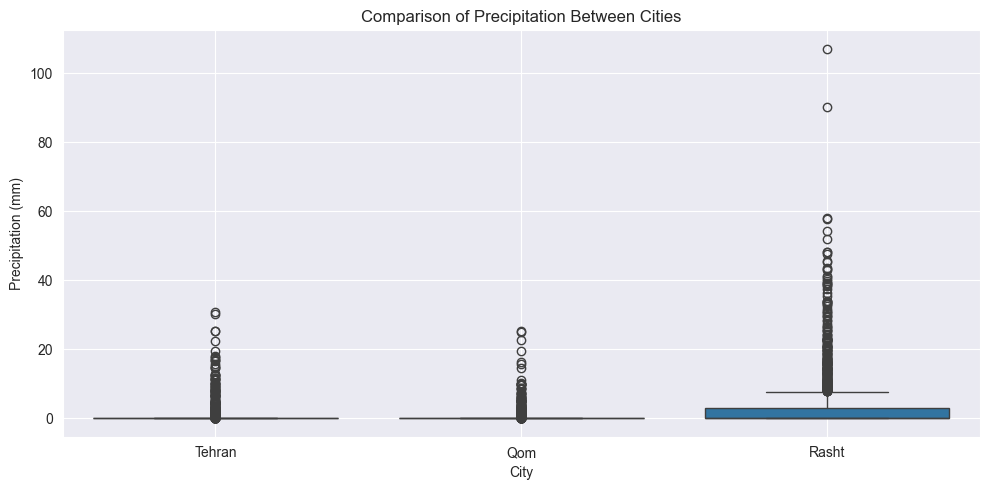

In [22]:
##در این نمودار  مشخص است که  دمای میانگین در قم از همه بیشتر و میانه‌ی آن بالاتر است، در حالی که رشت کمترین دامنه‌ی تغییرات دمایی را دارد . در نتیجه  همان طور که قبلا گفته شد دما با بارش رابطه عکس دارد

plt.figure(figsize=(10, 5))
sns.boxplot(data=main_df, x="city", y="temperature_2m_mean (°C)")
plt.title("Comparison of Average Temperature Between Cities")
plt.xlabel("City")
plt.ylabel("Mean Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


#مشاهده می شود که در رشت پراکندگی بارش خیلی بیشتره و کلی روزِ پربارش داره، ولی در تهران و قم اکثراً  بخاطر دمای بالایی دارند(همان طور که از نمودار بالا استنباط کردیم )یا اصلاً بارش نداریم یا خیلی کم هست .

plt.figure(figsize=(10, 5))
sns.boxplot(data=main_df, x="city", y="precipitation_sum (mm)")
plt.title("Comparison of Precipitation Between Cities")
plt.xlabel("City")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

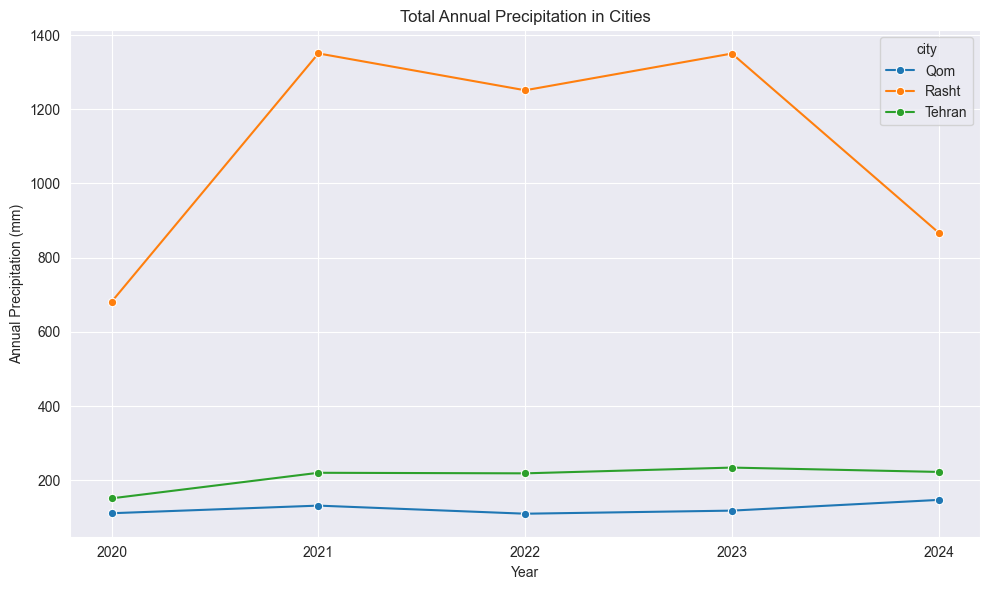

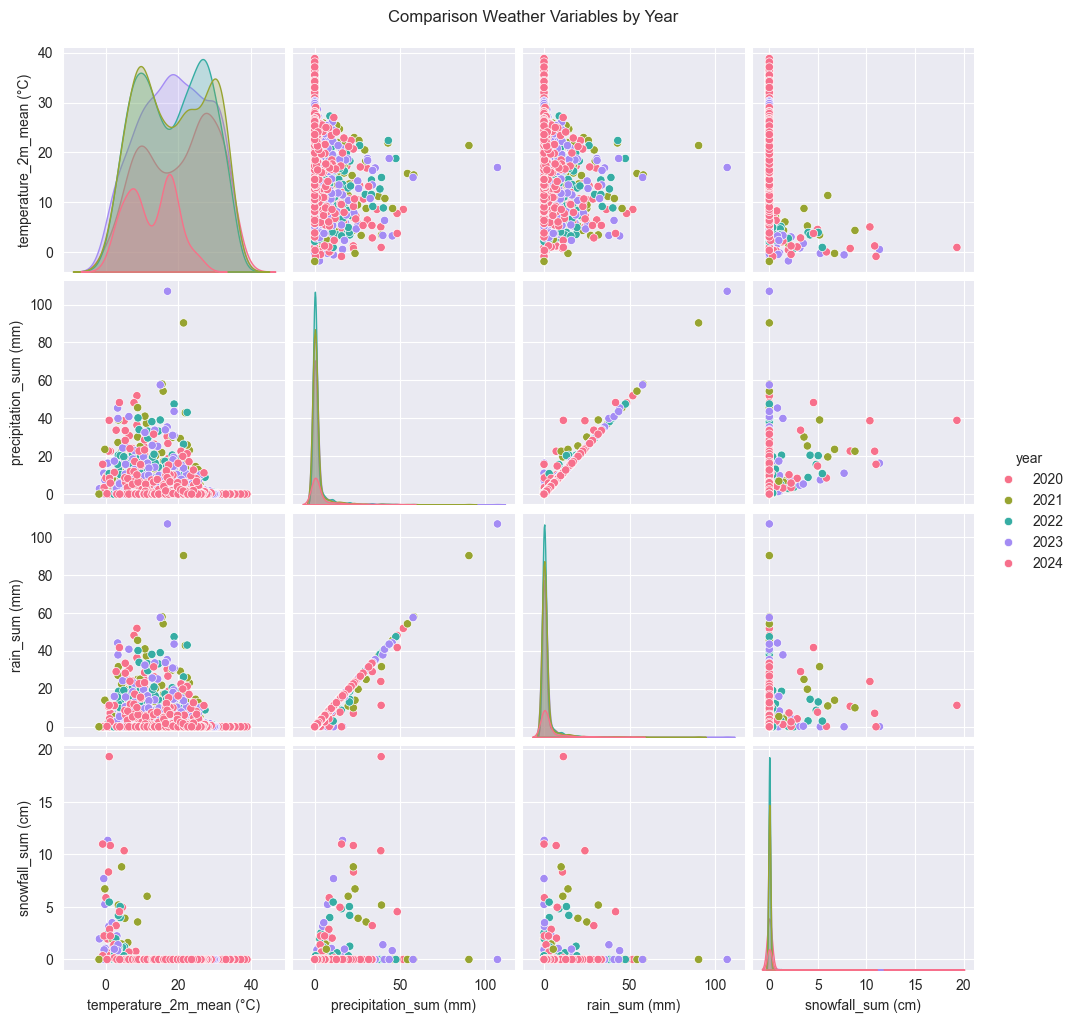

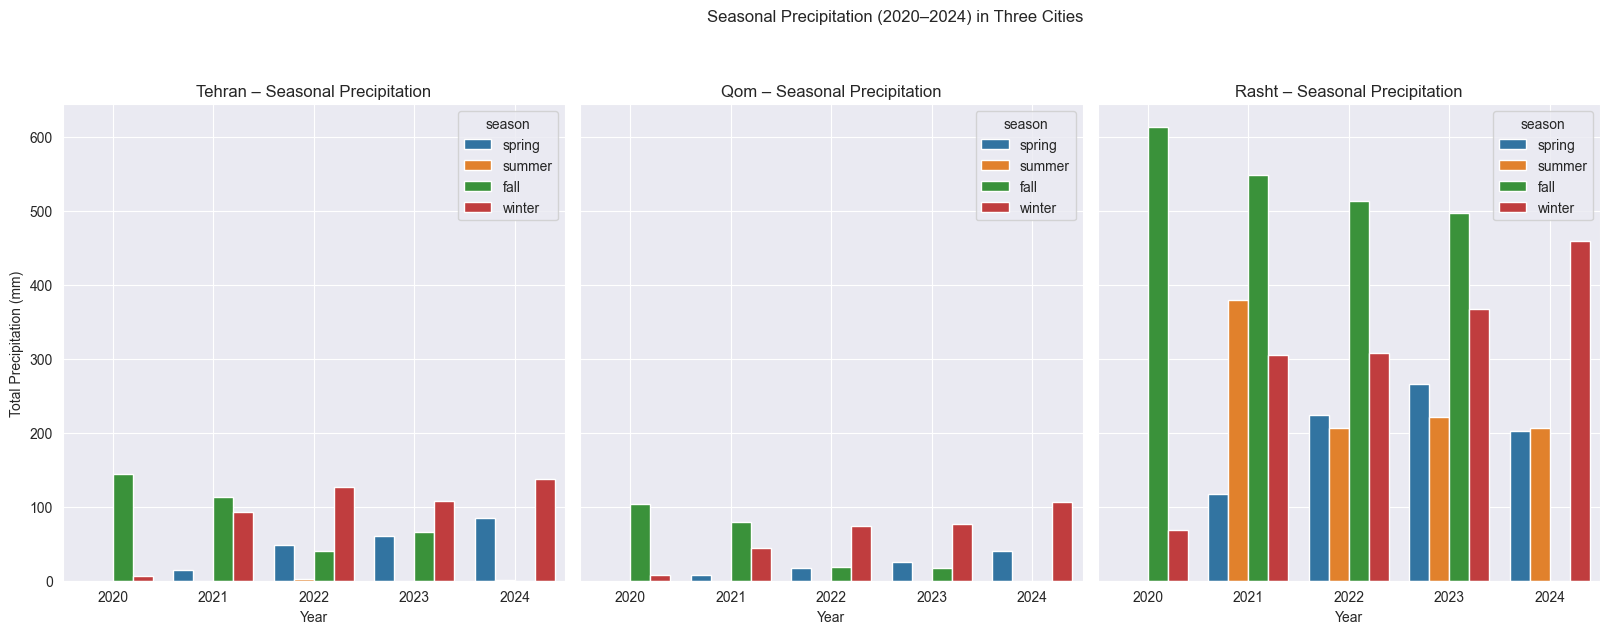

In [23]:
# در بازه ۲۰۲۰ تا ۲۰۲۴، رشت نوسانات شدید بارشی را تجربه کرده و در سال‌های ۲۰۲۱ و ۲۰۲۳ بیشترین بارش را داشته است، اما در ۲۰۲۴ افت چشمگیری داشته. تهران روندی نسبتاً پایدار و افزایشی تا ۲۰۲۳ داشته و در قم نیز بارندگی در سال ۲۰۲۴ به اوج خود رسیده است.
#

yearly_precip = (
    main_df
    .groupby(["city", "year"])["precipitation_sum (mm)"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_precip, x="year", y="precipitation_sum (mm)", hue="city", marker="o")
plt.title("Total Annual Precipitation in Cities")
plt.xlabel("Year")
plt.ylabel("Annual Precipitation (mm)")
plt.xticks(ticks=np.arange(yearly_precip["year"].min(), yearly_precip["year"].max() + 1, 1).astype(int))
plt.grid(True)
plt.tight_layout()
plt.show()




# همان طور که قبلا هم  استنباط شده بود، در روزهایی با دمای بالاتر، به‌طور معمول بارش کمتری رخ داده و بالعکس.
# در نمودار scatter میان precipitation_sum و rain_sum، یک همبستگی قوی مشاهده شده است و نشان دهنده این است که بخش عمده‌ای از بارش‌ها در طول سال‌های 2020 تا 2024 به ‌صورت باران بوده‌اند و سهم برف از بارش کلی کم بوده است.مقدار بارش برف  در بیشتر روزها برابر با صفر بوده این امر بیانگر آن است که بارش برف ‌ب یک پدیده نادر است یا در فصول سرد سال بوده است.داده های پرت هم که در بعضی نمودار ها وجود دارد ممکن است رویدادهای بارشی غیر معمول در برخی روزها بوده باشد


sns.pairplot(main_df[numeric_cols + ["year"]], hue="year", palette="husl", plot_kws={"alpha": 1})
plt.suptitle("Comparison Weather Variables by Year", y=1.02)
plt.show()




# این نمودار نشان می‌دهد که شهر رشت در تمام سال‌ها و فصل‌ها، به‌ویژه در پاییز و زمستان، بارش بسیار بیشتری نسبت به تهران و قم دارد. بارش در تهران نسبتاً متعادل‌تر است و در زمستان افزایش تدریجی دیده می‌شود. قم کم‌باران‌ترین شهر است و عمده بارش آن در پاییز و زمستان رخ می‌دهد.
#


season_order = ["spring", "summer", "fall", "winter"]
cities = ["Tehran", "Qom", "Rasht"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, city in enumerate(cities):
    city_data = main_df[main_df["city"] == city]

    seasonal = (
        city_data
        .groupby(["year", "season"])["precipitation_sum (mm)"]
        .sum()
        .reset_index()
    )

    sns.barplot(
        data=seasonal,
        x="year",
        y="precipitation_sum (mm)",
        hue="season",
        hue_order=season_order,
        ax=axes[i]
    )

    axes[i].set_title(f"{city} – Seasonal Precipitation")
    axes[i].set_xlabel("Year")
    if i == 0:
        axes[i].set_ylabel("Total Precipitation (mm)")
    else:
        axes[i].set_ylabel("")
    axes[i].grid(True)

handles, labels = axes[0].get_legend_handles_labels()

plt.suptitle("Seasonal Precipitation (2020–2024) in Three Cities", y=1.05)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()



Find common precipitation sequence

In [24]:
cities = clean_df["city"].unique().tolist()

season_names = {
    "spring": "بهار",
    "summer": "تابستان",
    "fall": "پاییز",
    "winter": "زمستان"
}


for season_en, season_fa in season_names.items():
    season_data = clean_df[clean_df["season"] == season_en]
    season_data = season_data[season_data["precipitation_sum (mm)"] > 0]
    season_data = season_data.sort_values("time")

    events = []

    for date in season_data["time"].unique():
        daily_data = season_data[season_data["time"] == date]
        for city in daily_data["city"].unique():
            events.append((date, city))

    events.sort()

    all_sequences = []
    for i in range(len(events)):
        visited_cities = [events[i][1]]
        for j in range(i + 1, len(events)):
            if events[j][1] not in visited_cities:
                visited_cities.append(events[j][1])
            if len(visited_cities) == 3:
                all_sequences.append(tuple(visited_cities))
                break

    if all_sequences:
        sequence_count = {}
        for seq in all_sequences:
            sequence_count[seq] = sequence_count.get(seq, 0) + 1

        sorted_sequences = sorted(sequence_count.items(), key=lambda x: x[1], reverse=True)
        most_common = sorted_sequences[0][0]
        most_common_str = " → ".join(most_common)

        table_data = []
        for seq, count in sorted_sequences:
            table_data.append([" → ".join(seq), count])

        table_data.append(["رایج ترین الگو: " + most_common_str, sequence_count[most_common]])

        print(f"\nالگوهای رایج بارش در فصل {season_fa}:\n")
        print(tabulate(table_data, headers=["Sequences", "Number of repetitions"], tablefmt="grid", stralign="center", numalign="center"))
    else:
        print(f"\nدر فصل {season_fa}: الگوی مشخصی یافت نشد")



الگوهای رایج بارش در فصل بهار:

+--------------------------------------+-------------------------+
|              Sequences               |  Number of repetitions  |
+======================================+=========================+
|         Rasht → Tehran → Qom         |           89            |
+--------------------------------------+-------------------------+
|         Rasht → Qom → Tehran         |           72            |
+--------------------------------------+-------------------------+
|         Qom → Rasht → Tehran         |           54            |
+--------------------------------------+-------------------------+
|         Tehran → Qom → Rasht         |           39            |
+--------------------------------------+-------------------------+
|         Tehran → Rasht → Qom         |           36            |
+--------------------------------------+-------------------------+
|         Qom → Tehran → Rasht         |           10            |
+----------------------------